In [ ]:

import sys
sys.path.append("..")
import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
MODEL_PATH = "../models/model.pkl"
model = joblib.load(MODEL_PATH)

In [3]:
X_train = pd.read_parquet("../data/interim/preprocessed/X_train.parquet")
y_train = pd.read_parquet("../data/interim/preprocessed/y_train.parquet")
X_test = pd.read_parquet("../data/interim/preprocessed/X_test.parquet")
y_test = pd.read_parquet("../data/interim/preprocessed/y_test.parquet")

In [ ]:
def error_analysis(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    feature_names=None,
    train_model=False,
    prediction_title="Regression Model: Predicted vs Target",
    error_title="Distribution of Regression Model Error",
    xlim_min=-1 * 10**5,
    xlim_max=10**5,
):
    """
    Effectue l'analyse des erreurs pour un modèle donné sur les ensembles d'entraînement et de test,
    et génère des graphiques pour explorer les performances.

    Parameters:
    -----------
    model : object
        Modèle de machine learning. Si `train_model=True`, il doit avoir une méthode `fit`.
    X_train : pd.DataFrame or np.array
        Ensemble de données d'entraînement.
    y_train : pd.Series or np.array
        Cibles d'entraînement.
    X_test : pd.DataFrame or np.array
        Ensemble de données de test.
    y_test : pd.Series or np.array
        Cibles de test.
    feature_names : list or None, optional
        Liste des noms des colonnes à utiliser pour la prédiction. Si None, toutes les colonnes seront utilisées.
    train_model : bool, optional
        Si True, entraîne le modèle sur les données d'entraînement avant de réaliser l'analyse.
    prediction_title : str, optional
        Titre pour le graphique des prédictions vs les cibles.
    error_title : str, optional
        Titre pour le graphique de distribution des erreurs.
    xlim_min : float, optional
        Limite inférieure pour l'axe des x dans les graphiques.
    xlim_max : float, optional
        Limite supérieure pour l'axe des x dans les graphiques.

    Returns:
    --------
    dict
        Dictionnaire contenant les métriques d'erreur pour les ensembles d'entraînement et de test.
    """
    if feature_names:
        X_train = X_train[feature_names]
        X_test = X_test[feature_names]

    # Entraînement du modèle si demandé
    if train_model:
        model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Conversion en numpy arrays 1D
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    y_train_pred = y_train_pred.ravel()
    y_test_pred = y_test_pred.ravel()


    # Calcul des métriques pour l'entraînement
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Calcul des métriques pour le test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Analyse des erreurs absolues
    absolute_errors_train = pd.Series(
        [abs(true_value - predicted_value) for (true_value, predicted_value) in zip(y_train, y_train_pred)]
    )
    absolute_errors_test = pd.Series(
        [abs(true_value - predicted_value) for (true_value, predicted_value) in zip(y_test, y_test_pred)]
    )


    # Stockage des métriques dans un dictionnaire
    metrics = {
        "Train RMSE": train_rmse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test RMSE": test_rmse,
        "Test MAE": test_mae,
        "Test R2": test_r2,
    }

    # Affichage des résultats
    print("\n--- Metrics ---")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Affichage des statistiques descriptives des erreurs absolues
    print("\n--- Absolute Errors (Train) ---")
    print(absolute_errors_train.describe().apply(lambda x: format(x, "f")))

    print("\n--- Absolute Errors (Test) ---")
    print(absolute_errors_test.describe().apply(lambda x: format(x, "f")))


    # Plot des prédictions vs cibles
    def plot_regression_predictions(X, y, y_pred, title):
        plt.figure(figsize=(8, 6))
        plt.scatter(y, y_pred, alpha=0.5, edgecolors="k")
        plt.plot(
            [min(y), max(y)],
            [min(y), max(y)],
            color="red",
            linestyle="--",
            label="Ideal Prediction",
        )
        plt.xlabel("Target")
        plt.ylabel("Predicted")
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_regression_error(y, y_pred, title, xlim_min, xlim_max):
        plt.figure(figsize=(8, 6))
        errors = y - y_pred
        sns.kdeplot(errors, color="blue", fill=True, alpha=0.3)  # Courbe de densité lissée
        plt.axvline(0, color="red", linestyle="--", label="Zero Error")
        plt.xlim(xlim_min, xlim_max)
        plt.xlabel("Error")
        plt.ylabel("Density")
        plt.title(title)
        plt.legend()
        plt.show()
    # Visualisations
    plot_regression_predictions(X_train, y_train, y_train_pred, f"{prediction_title} (Train Set)")
    plot_regression_predictions(X_test, y_test, y_test_pred, f"{prediction_title} (Test Set)")

    plot_regression_error(y_train, y_train_pred, f"{error_title} (Train Set)", xlim_min, xlim_max)
    plot_regression_error(y_test, y_test_pred, f"{error_title} (Test Set)", xlim_min, xlim_max)

    return metrics





--- Metrics ---
Train RMSE: 125751.0112
Train MAE: 57800.4612
Train R2: 0.7958
Test RMSE: 150461.8962
Test MAE: 59022.2338
Test R2: 0.7241

--- Absolute Errors (Train) ---
count     413441.000000
mean       57800.461157
std       111680.139991
min            0.005241
25%        12932.058910
50%        29732.142774
75%        61916.011283
max      7165986.897393
dtype: object

--- Absolute Errors (Test) ---
count      103361.000000
mean        59022.233833
std        138402.830320
min             0.516478
25%         12876.433924
50%         29623.371723
75%         61808.443923
max      10998277.039390
dtype: object


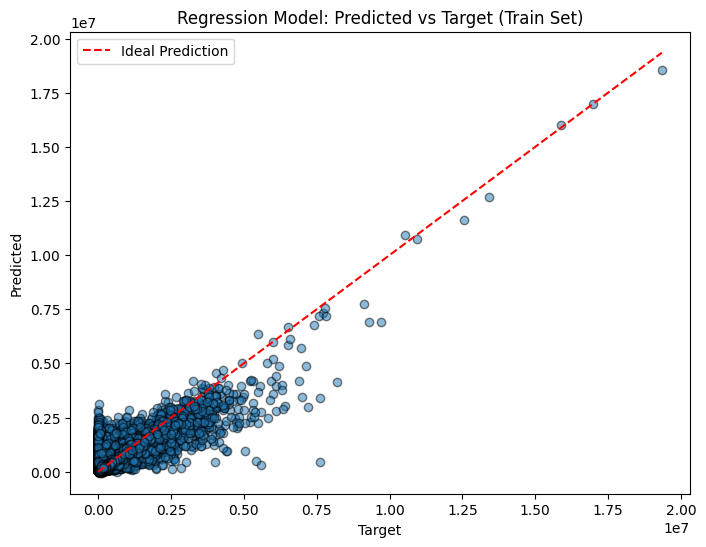

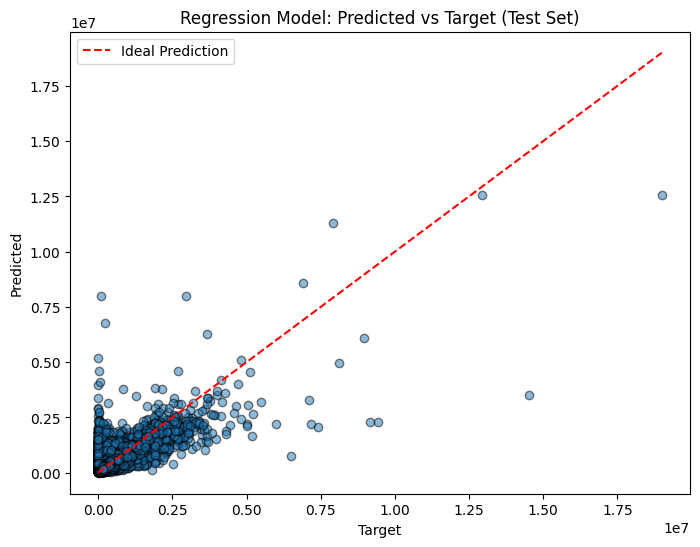

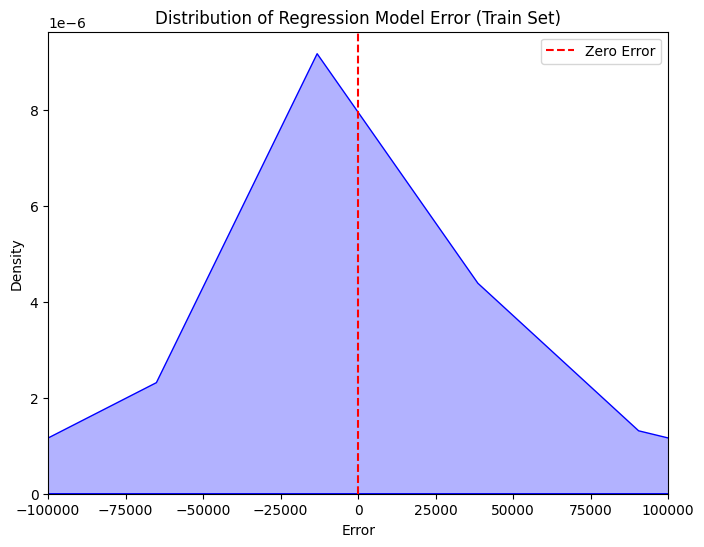

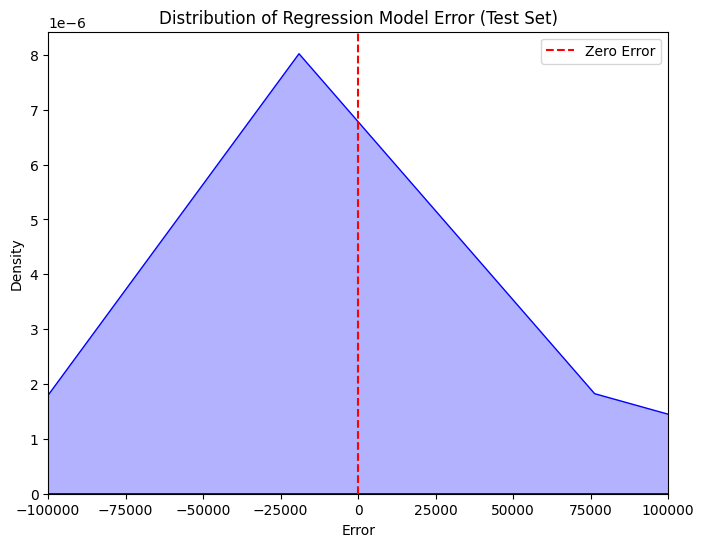

{'Train RMSE': 125751.01117309953,
 'Train MAE': 57800.461157279206,
 'Train R2': 0.7958172656257385,
 'Test RMSE': 150461.8961816822,
 'Test MAE': 59022.23383273925,
 'Test R2': 0.7241214271123441}

In [5]:
error_analysis(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    feature_names=None,
    train_model=False,
    prediction_title="Regression Model: Predicted vs Target",
    error_title="Distribution of Regression Model Error",
    xlim_min=-1 * 10**5,
    xlim_max=10**5,
)